# Neurog Internship: (Task 6 - Implementation Of Machine Learning & Deep Learning For The Prediction Of Close Price. Then, Perform Back Testing On Previous 1 Year Data)

## All Libraries

In [1]:
# For Vizualization & Plotting
import matplotlib.pyplot as plt

# Scikit-Learn Modules For Machine Learning
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Scikit-Learn Modules For Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Scikit-Learn Modules For Data Manipulation (Train Valid Test Splits)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Keras Modules For Deep Learning
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Other Necessary Libraries
import pandas as pd
import numpy as np
import copy

## All Declarations

In [ ]:
# Define the relative path to the CSV file
csv_filename = "BTCUSDT_1_Minute_From_2020_Till_Now.csv"

# Settig Up The Directory From The Directory Hierarchy
# Get the notebook's current directory
notebook_dir = os.path.dirname(os.path.abspath(__file__))

# Go up one level to the parent directory
parent_dir = os.path.dirname(script_dir)

# Create the full path to the output CSV file in the 'ohlc' directory within 'data'
data_dir = os.path.join(parent_dir, "data")
ohlc_dir = os.path.join(data_dir, "ohlc")
full_csv_path = os.path.join(ohlc_dir, csv_filename)

## Utility Functions

In [2]:
# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - Mean Squared Error: {mse:.4f}, R² Score: {r2:.4f}")
    
    
def plot_past_plus_predicted(data, predictions, train_len):
    # Plot the data
    # Create a DataFrame for the valid set
    past = data[:train_len].copy()
    future = data[train_len:].copy()
    
    if isinstance(past, pd.Series):
        past = past.to_frame()
        
    if isinstance(future, pd.Series):
        future = future.to_frame()
    
    future['Predictions'] = predictions

    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(past)
    plt.plot(future[['Close', 'Predictions']])
    plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
    plt.show()

## (Function To Convert DF To Any Timeframe) - Taken From The Previous Day

In [3]:
# Functions converts the dataframe into any given time frame.
def convert_1m_to_any_timeframe(df: pd.DataFrame, timeframe: str) -> pd.DataFrame:
    """
    Convert a DataFrame of 1-minute OHLC data to any given timeframe.

    Args:
    - df (pd.DataFrame): DataFrame containing 1-minute OHLC data. 
      The DataFrame should have a datetime index & columns ['Open', 'High', 'Low', 'Close', 'Volume'].
    - timeframe (str): The desired timeframe to resample the data to (e.g., '1H' for 1 hour, '1D' for 1 day).

    Returns:
    - pd.DataFrame: Resampled DataFrame with OHLC data in the specified timeframe. The index will be renamed to
      reflect the new timeframe.

    Example:
    ```
    resampled_df = convert_1m_to_any_timeframe(ohlc_df, '1H')
    ```
    """
    # Ensure the DataFrame index is of datetime type
    df.index = pd.to_datetime(df.index)
    
    # Try resampling the data to the desired timeframe
    try:
        df_resampled = df.resample(timeframe).agg({
            'Open': 'first',  # Take the first 'Open' value in the timeframe
            'High': 'max',    # Take the maximum 'High' value in the timeframe
            'Low': 'min',     # Take the minimum 'Low' value in the timeframe
            'Close': 'last',  # Take the last 'Close' value in the timeframe
            'Volume': 'mean'  # Take the mean 'Volume' value in the timeframe
        })
    except Exception as e:
        print(f"An error occurred while resampling! Error message: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

    # Rename the index to reflect the new timeframe
    df_resampled.index.rename(f'Open time ({timeframe})', inplace = True)
    
    return df_resampled

## Function To Calculate Profit & Loss (PNL) Through The Generated Backtest DataFrame

In [4]:
# Function to calculate pnl (profit & loss)
def calculate_pnl(entry_price, close_price, direction):
    """
    Calculate Profit and Loss (PNL) as a percentage.

    Args:
        entry_price (float): The price at which the trade was entered.
        close_price (float): The price at which the trade was closed.
        direction (str): The direction of the trade, either 'long' or 'short'.

    Returns:
        float: The PNL as a percentage, rounded to 2 decimal places.
    """
    if direction == 'long':
        pnl_percent = ((close_price - entry_price) / entry_price) * 100
    elif direction == 'short':
        pnl_percent = ((entry_price - close_price) / entry_price) * 100
    else:
        raise ValueError("Invalid direction. Use 'long' or 'short'.")

    return round(pnl_percent, 2)

## MACD Indicator Function

In [5]:
def calculate_macd(df: pd.DataFrame, short_window: int = 12, long_window: int = 26, signal_window: int = 9) -> pd.DataFrame:
    """
    Calculate the MACD (Moving Average Convergence Divergence) for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - short_window (int): The window size for the short-term EMA, default is 12.
    - long_window (int): The window size for the long-term EMA, default is 26.
    - signal_window (int): The window size for the Signal line, default is 9.

    Returns:
    - pd.DataFrame: DataFrame with the MACD line and Signal line.
    """
    # Calculate the short-term and long-term EMAs
    df['EMA_12'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD line
    df['MACD'] = df['EMA_12'] - df['EMA_26']

    # Calculate the Signal line
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    return df

def generate_macd_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on MACD values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'MACD' and 'Signal_Line' values.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['Signal'] = 0  # Default no signal
    df.loc[df['MACD'] > df['Signal_Line'], 'Signal'] = 1  # Buy signal
    df.loc[df['MACD'] < df['Signal_Line'], 'Signal'] = -1  # Sell signal

    return df

## Main Driver Function: Function To Generate Backtested DataFrame

In [6]:
def generate_backtest_df(data):
    """
    Generate a backtesting DataFrame based on MACD signals.

    Args:
        data (pd.DataFrame): DataFrame containing historical data with columns:
                             'Open time (4H)', 'Open', 'High', 'Low', 'Close', 'Volume', 'MACD_Signal'.
                             The DataFrame must have 'Open time (4H)' as the DateTime index.

    Returns:
        pd.DataFrame: A DataFrame containing the backtesting results with columns:
                      'Open time (4H)', 'direction', 'entry price', 'close price'.
    """
    # Create a new DataFrame for backtesting results
    backtest_df = pd.DataFrame(columns=['Open time (4H)', 'direction', 'entry price', 'close price'])

    # Initialize variables for tracking positions
    current_signal = None
    counter = 0

    # Iterate through rows of the original DataFrame
    for index, row in data.iterrows():
        signal = row['Signal']

        if signal == 0:
            continue  # Skip rows where MACD_Signal is 0

        if current_signal is None:
            # First entry
            if signal == 1:
                direction = 'long'
            elif signal == -1:
                direction = 'short'
                
            entry_price = row['Open']  # Initial entry price

            # Add the first row to backtest_df
            backtest_df.loc[counter, ['Open time (4H)', 'direction', 'entry price', 'close price']] = [index, direction, entry_price, 0]
            current_signal = signal
            counter += 1
            
        elif (signal + current_signal) == 0:
            # Signal change detected
            # Add a new row to the dataframe
            if signal == 1:
                direction = 'long'
            elif signal == -1:
                direction = 'short'
                
            entry_price = backtest_df.iloc[counter - 1]['entry price']
            close_price = row['Open']
            backtest_df.loc[counter, ['Open time (4H)', 'direction', 'entry price', 'close price']] = [index, direction, entry_price, close_price]

            # Update current signal
            current_signal = signal
            counter += 1

            # Add another row
            backtest_df.loc[counter, ['Open time (4H)', 'direction', 'entry price', 'close price']] = [index, direction, close_price, 0]
            counter += 1

    return backtest_df

## Main

### Reading The Previously Saved Data For BTCUSDT

In [7]:
BTCUSDT_Filtered_data_1M = pd.read_csv(full_csv_path)
BTCUSDT_Filtered_data_1M.set_index('Open time (1M)', inplace = True)

# Convert the index to datetime format
BTCUSDT_Filtered_data_1M.index = pd.to_datetime(BTCUSDT_Filtered_data_1M.index)

In [8]:
BTCUSDT_Filtered_data_1M

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
Open time (1M),,,,,,,,,
2020-01-01 00:00:00,7169.71,7169.71,7165.44,7167.83,3509.860,2.515594e+07,139.0,1025.400,7.348382e+06
2020-01-01 00:01:00,7167.83,7168.28,7158.66,7159.95,3821.170,2.737640e+07,155.0,1571.990,1.126101e+07
2020-01-01 00:02:00,7161.03,7165.40,7161.03,7162.46,3041.710,2.178758e+07,122.0,1439.790,1.031332e+07
2020-01-01 00:03:00,7161.74,7164.27,7160.30,7161.03,3682.650,2.637680e+07,147.0,1557.630,1.115700e+07
2020-01-01 00:04:00,7161.03,7164.25,7160.15,7160.15,2936.690,2.103310e+07,113.0,1407.430,1.007968e+07
...,...,...,...,...,...,...,...,...,...
2024-07-05 10:41:00,55700.00,55700.00,55397.30,55500.00,1.283,7.120373e+04,23.0,0.010,5.555000e+02
2024-07-05 10:42:00,55500.00,55562.40,54959.50,55500.00,4.314,2.385602e+05,45.0,2.111,1.170360e+05
2024-07-05 10:43:00,55500.00,55500.00,54760.00,54923.90,8.064,4.438382e+05,48.0,1.990,1.101392e+05


### Display Graph For Close Price (1 Minute Interval)

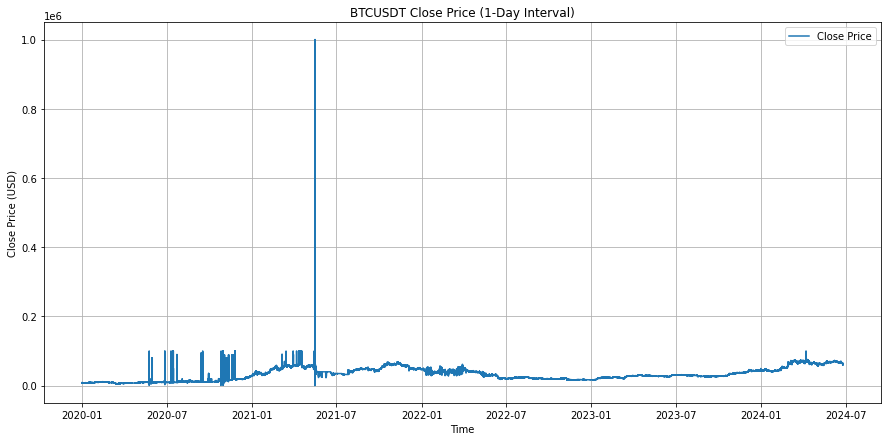

In [11]:
# Plot the 'Close' price over time
plt.figure(figsize=(15, 7))
plt.plot(BTCUSDT_Filtered_data_1M['Close'], label='Close Price')
plt.title('BTCUSDT Close Price (1-Day Interval)')
plt.xlabel('Time')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Now, Enough Plotting! On The Task!

## Generate Different Timeframe

### Converting 1 Minute Interval Data to 4 Hour Interval Data

In [9]:
BTCUSDT_Filtered_data_4H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '4H')
BTCUSDT_Filtered_data_4H

,Open,High,Low,Close,Volume
Open time (4H),,,,,
2020-01-01 00:00:00,7169.71,7207.23,7156.65,7202.48,3428.062092
2020-01-01 04:00:00,7202.48,9592.00,6871.45,7241.63,285722.475587
2020-01-01 08:00:00,7241.63,7243.46,7215.94,7223.72,3629.004242
2020-01-01 12:00:00,7223.71,7233.33,7178.00,7201.02,3491.032767
2020-01-01 16:00:00,7201.56,7236.58,7187.86,7220.85,3125.298729
...,...,...,...,...,...
2024-07-04 16:00:00,57890.00,58600.00,56666.00,57628.80,50.266283
2024-07-04 20:00:00,57628.80,59111.00,57438.20,58768.00,7.108233
2024-07-05 00:00:00,58650.70,59706.50,57000.10,58359.00,11.704692


### Converting 1 Minute Interval Data to 24 Hour (1 Day) Interval Data

In [10]:
BTCUSDT_Filtered_data_1D = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '1D')
BTCUSDT_Filtered_data_1D

,Open,High,Low,Close,Volume
Open time (1D),,,,,
2020-01-01,7169.71,9592.00,6871.45,7242.21,50472.792781
2020-01-02,7242.21,7243.41,6934.53,6975.70,3348.620363
2020-01-03,6975.70,7600.00,6871.45,7342.00,3584.646061
2020-01-04,7342.00,7400.00,7260.00,7305.62,3105.244637
2020-01-05,7305.68,7492.05,7260.00,7438.62,2969.803410
...,...,...,...,...,...
2024-07-01,61706.50,69407.00,61351.00,64010.00,13.664674
2024-07-02,64160.90,64160.90,62250.00,63077.30,4.420171
2024-07-03,63077.30,63417.50,59032.00,59865.00,13.074811


## Basic & Advanced Machine Learning & Deep Learning Models For 1 Day Interval Data

### Using ML Models

In [53]:
# Features and target variable
X = BTCUSDT_Filtered_data_1D[['Open', 'High', 'Low', 'Volume']]
y = BTCUSDT_Filtered_data_1D['Close']

# # Use If You Want To Predict Random Values
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data into training and testing sets
split_index = -60  # Last 60 values for y_train and y_test

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor()
forest_model = RandomForestRegressor(n_estimators=100)
gboost_model = GradientBoostingRegressor()
svr_model = SVR()

# Train models
linear_model.fit(X_train_scaled, y_train)
tree_model.fit(X_train, y_train)  # Decision Tree does not require scaling
forest_model.fit(X_train, y_train)  # Random Forest does not require scaling
gboost_model.fit(X_train_scaled, y_train)
svr_model.fit(X_train_scaled, y_train)

# Predict using the models
y_pred_linear = linear_model.predict(X_test_scaled)
y_pred_tree = tree_model.predict(X_test)
y_pred_forest = forest_model.predict(X_test)
y_pred_gboost = gboost_model.predict(X_test_scaled)
y_pred_svr = svr_model.predict(X_test_scaled)

# Evaluate All Models
evaluate_model(y_test, y_pred_linear, "Linear Regression")
evaluate_model(y_test, y_pred_tree, "Decision Tree Regression")
evaluate_model(y_test, y_pred_forest, "Random Forest Regression")
evaluate_model(y_test, y_pred_gboost, "Gradient Boosting Regression")
evaluate_model(y_test, y_pred_svr, "Support Vector Regression")

Linear Regression - Mean Squared Error: 1061791.5597, R² Score: 0.8869
Decision Tree Regression - Mean Squared Error: 1021012.2570, R² Score: 0.8912
Random Forest Regression - Mean Squared Error: 567627.5771, R² Score: 0.9395
Gradient Boosting Regression - Mean Squared Error: 1091775.2932, R² Score: 0.8837
Support Vector Regression - Mean Squared Error: 1331779963.1794, R² Score: -140.9030


### Plotting Predicted Close Price Line Using Linear Regression

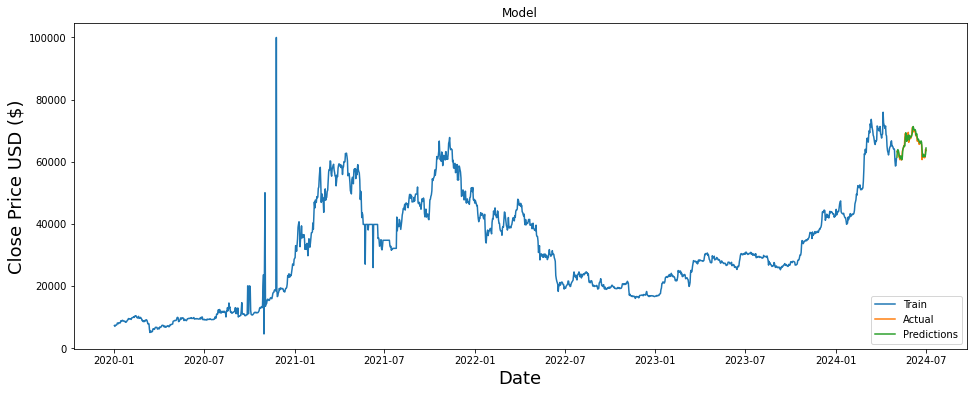

In [92]:
plot_past_plus_predicted(BTCUSDT_Filtered_data_1D['Close'] ,y_pred_linear, len(X_train))

### Plotting Predicted Close Price Line Using Decision Tree Regression

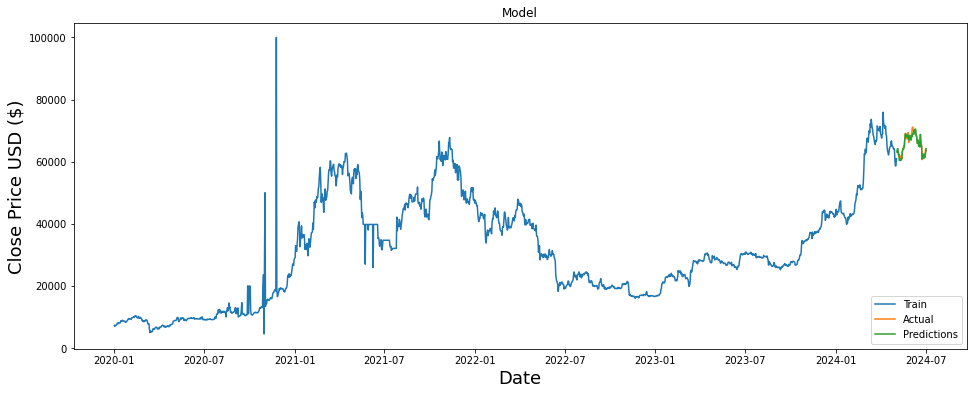

In [93]:
plot_past_plus_predicted(BTCUSDT_Filtered_data_1D['Close'] ,y_pred_tree, len(X_train))

### Plotting Predicted Close Price Line Using Random Forest Regression

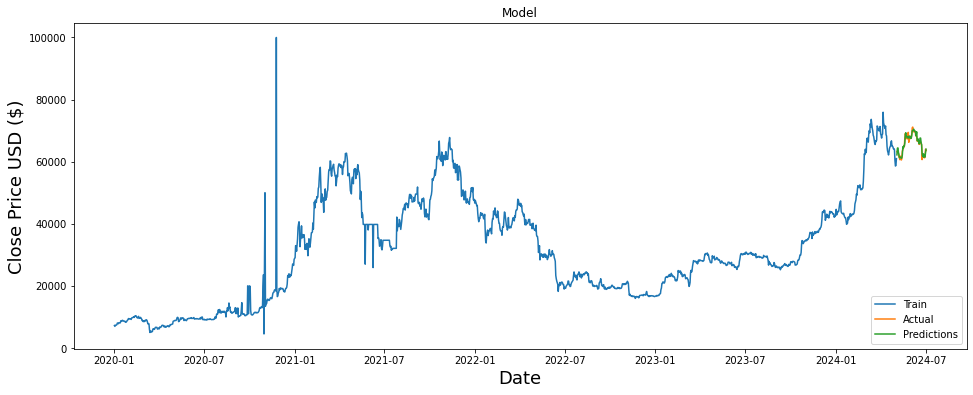

In [94]:
plot_past_plus_predicted(BTCUSDT_Filtered_data_1D['Close'] ,y_pred_forest, len(X_train))

### Plotting Predicted Close Price Line Using Gradient Boosting Regression

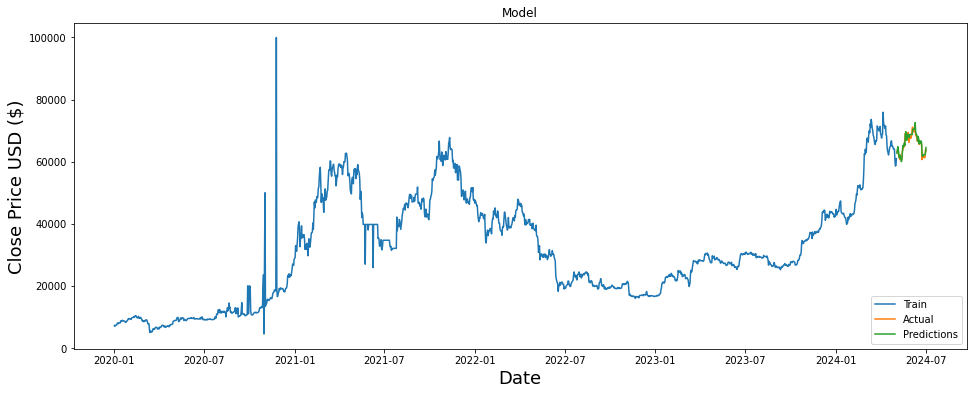

In [95]:
plot_past_plus_predicted(BTCUSDT_Filtered_data_1D['Close'] ,y_pred_gboost, len(X_train))

### Plotting Predicted Close Price Line Using Support Vector Regression

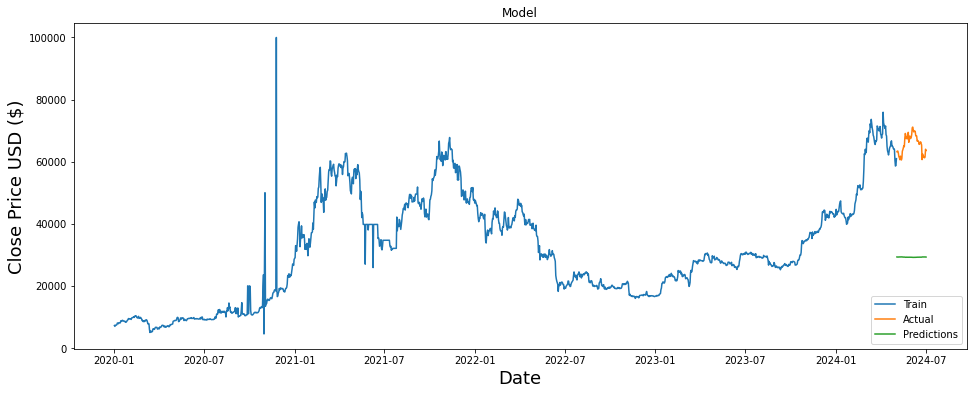

In [96]:
plot_past_plus_predicted(BTCUSDT_Filtered_data_1D['Close'] ,y_pred_svr, len(X_train))

### Using DL Models: LSTM

### Extracting Only The Close Column

In [32]:
# Create a new dataframe with only the 'Close column 
data = BTCUSDT_Filtered_data_1D.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

1563

### Scaling The Data

In [33]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02851069],
       [0.02571942],
       [0.02955583],
       ...,
       [0.59730725],
       [0.62306238],
       [0.61855777]])

### Creating The Training Dataset

In [34]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

[array([0.02851069, 0.02571942, 0.02955583, 0.0291748 , 0.03056777,
       0.03153813, 0.03684636, 0.03699204, 0.03447832, 0.03665019,
       0.03819041, 0.0376901 , 0.03759196, 0.04450775, 0.04429619,
       0.04359374, 0.0460552 , 0.04570246, 0.04324739, 0.04340878,
       0.04308735, 0.04346167, 0.04001173, 0.0415287 , 0.04004577,
       0.04249435, 0.04572152, 0.0469069 , 0.05082217, 0.05214475,
       0.05024822, 0.0510022 , 0.05153802, 0.05014778, 0.04895287,
       0.05378729, 0.05498492, 0.05528258, 0.05572958, 0.05823723,
       0.05572215, 0.05961448, 0.06099257, 0.05950168, 0.06114318,
       0.05650849, 0.05530688, 0.05366119, 0.05722236, 0.0594246 ,
       0.0524889 , 0.05427043, 0.05377881, 0.05609804, 0.05307615,
       0.05084479, 0.04521272, 0.04573723, 0.04209814, 0.0434336 ])]
[0.04123125693666285]

[array([0.02851069, 0.02571942, 0.02955583, 0.0291748 , 0.03056777,
       0.03153813, 0.03684636, 0.03699204, 0.03447832, 0.03665019,
       0.03819041, 0.0376901 , 0.03

(1503, 60, 1)

### Building The Model, Compiling It & Training It On The Training Data

In [35]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1503/1503 [==============================] - 55s 33ms/step - loss: 0.0025


### Creating The Testing Dataset

In [36]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

3/3 [==============================] - 2s 36ms/step


3148.4348647797133

### Plotting Predicted Close Price Line Using Long Short Term Memory (LSTM)

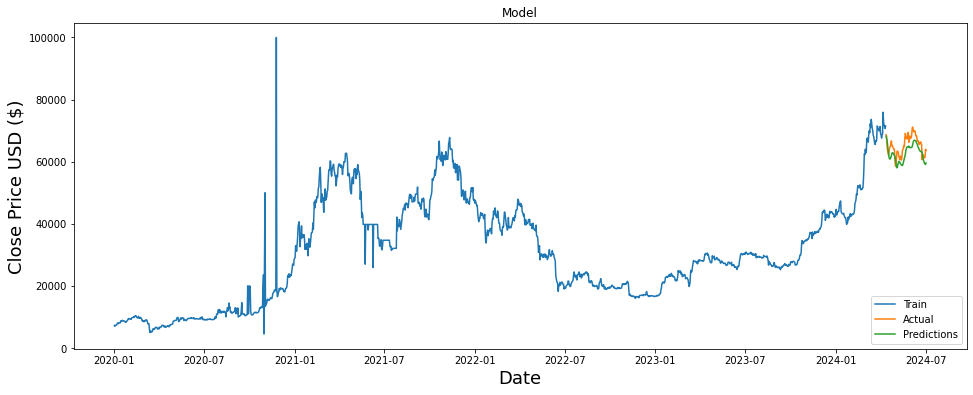

In [99]:
plot_past_plus_predicted(data, predictions, training_data_len)

## Making Custom Trading Signal Generator Using LSTM & Custom Magnitude Calculator
### - Still In The Making (Ignoring This For The Time Being)

In [ ]:
def gain_calculator(fiat_amount,price_at_buy,price_at_sell):
    crypto_amount = (fiat_amount- (fiat_amount*0.25/100))/price_at_buy
    gain_from_sell = (price_at_sell * crypto_amount) - (price_at_sell * crypto_amount * 0.25/100)
    return gain_from_sell - fiat_amount

In [ ]:
def required_magnitude(current_price,fiat_amount):
    x = 0 
    while True:
        gain = gain_calculator(fiat_amount,current_price,current_price+x)
        if gain>0:
            break
        else:
            x += 0.01
    return x

In [ ]:
#predict future price using trained LSTM
pred_price = model.predict(historical_price)
#get current price
current_price = get_current_price()
#calcualet required magnitude of increase in price
mag = required_magnitude(current_price,fiat_amount)
#determine action
if pred_pricec - urrent_price >= mag:
    #buy
elif pred_price < current_price:
    #sell
else:
    #do nothing

## Performing Back Testing

### Using Signals Generated From MACD On 1 Year Data Of 4-Hour Time Interval

### Extracting 1 Year Data

In [11]:
# Fetch 1 Year Data
BTCUSDT_Filtered_data_4H_Prev_1_Year = BTCUSDT_Filtered_data_4H.loc['2023-07-02' : '2024-07-02']
BTCUSDT_Filtered_data_4H_Prev_1_Year

,Open,High,Low,Close,Volume
Open time (4H),,,,,
2023-07-02 00:00:00,30598.0,30700.0,30418.0,30679.9,66.690854
2023-07-02 04:00:00,30679.9,30700.0,30300.5,30432.1,63.147079
2023-07-02 08:00:00,30432.1,30637.0,30160.1,30379.4,66.269358
2023-07-02 12:00:00,30379.4,30636.0,30251.0,30441.7,69.949029
2023-07-02 16:00:00,30379.3,30499.0,30185.1,30406.9,71.054587
...,...,...,...,...,...
2024-07-02 04:00:00,64073.8,64160.9,63010.0,63100.3,4.206158
2024-07-02 08:00:00,63343.3,63999.9,63030.6,63051.1,4.505912
2024-07-02 12:00:00,63278.6,63712.6,62260.0,62826.0,7.381213


### Generating Signas Using MACD Indicator Function

In [12]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_4H_Prev_1_Year))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd = BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd

,Open,High,Low,Close,Volume,Signal
Open time (4H),,,,,,
2023-07-02 00:00:00,30598.0,30700.0,30418.0,30679.9,66.690854,0
2023-07-02 04:00:00,30679.9,30700.0,30300.5,30432.1,63.147079,-1
2023-07-02 08:00:00,30432.1,30637.0,30160.1,30379.4,66.269358,-1
2023-07-02 12:00:00,30379.4,30636.0,30251.0,30441.7,69.949029,-1
2023-07-02 16:00:00,30379.3,30499.0,30185.1,30406.9,71.054587,-1
...,...,...,...,...,...,...
2024-07-02 04:00:00,64073.8,64160.9,63010.0,63100.3,4.206158,1
2024-07-02 08:00:00,63343.3,63999.9,63030.6,63051.1,4.505912,1
2024-07-02 12:00:00,63278.6,63712.6,62260.0,62826.0,7.381213,1


### Applying The Backtesting Algorithm

In [13]:
backtest_df = generate_backtest_df(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd)
backtest_df

,Open time (4H),direction,entry price,close price
0,2023-07-02 04:00:00,short,30679.9,0
1,2023-07-03 20:00:00,long,30679.9,30490.0
2,2023-07-03 20:00:00,long,30490.0,0
3,2023-07-05 12:00:00,short,30490.0,30820.0
4,2023-07-05 12:00:00,short,30820.0,0
...,...,...,...,...
414,2024-06-27 00:00:00,long,61418.2,0
415,2024-06-27 04:00:00,short,61418.2,61786.6
416,2024-06-27 04:00:00,short,61786.6,0
417,2024-06-27 16:00:00,long,61786.6,61415.4


### Calculating Profit & Loss (PNL) For The Backtesting

In [93]:
# Add PNL column to the backtest_df
backtest_df['PNL'] = 0.0

# Calculate PNL for each completed trade
for i in range(1, len(backtest_df), 2):
    entry_price = float(backtest_df.iloc[i]['entry price'])
    close_price = float(backtest_df.iloc[i]['close price'])
    direction = backtest_df.iloc[i - 1]['direction']
    pnl = calculate_pnl(entry_price, close_price, direction)
    backtest_df.loc[i, 'PNL'] = pnl
    
backtest_df

,Open time (4H),direction,entry price,close price,PNL
0,2023-07-02 04:00:00,short,30679.9,0,0.00
1,2023-07-03 20:00:00,long,30679.9,30490.0,0.62
2,2023-07-03 20:00:00,long,30490.0,0,0.00
3,2023-07-05 12:00:00,short,30490.0,30820.0,1.08
4,2023-07-05 12:00:00,short,30820.0,0,0.00
...,...,...,...,...,...
414,2024-06-27 00:00:00,long,61418.2,0,0.00
415,2024-06-27 04:00:00,short,61418.2,61786.6,0.60
416,2024-06-27 04:00:00,short,61786.6,0,0.00
417,2024-06-27 16:00:00,long,61786.6,61415.4,0.60


### Displaying Cumulative Profit & Loss (PNL)

In [94]:
total_PNL = backtest_df['PNL'].sum()
total_PNL

297.77

## Time Analysis On The Backtest Function

### Extracting 2 Years Data & Applying MACD To Generate Signals

In [ ]:
# Fetch 2 Year Data
BTCUSDT_Filtered_data_4H_Prev_2_Year = BTCUSDT_Filtered_data_4H.loc['2022-07-02': '2024-07-02']

# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_4H_Prev_2_Year_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_4H_Prev_2_Year))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_4H_Prev_2_Year_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_4H_Prev_2_Year_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_4H_Prev_2_Year_with_macd = BTCUSDT_Filtered_data_4H_Prev_2_Year_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_4H_Prev_2_Year_with_macd

### Running The Code 10 Times Per Loop Which Will Run For 5 Times

In [ ]:
%%timeit -n 10 -r 5
backtest_df = generate_backtest_df(BTCUSDT_Filtered_data_4H_Prev_2_Year_with_macd)

#### The Time Analysis Report:
- 938 ms ± 272 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)

# ***More Later!***